# JPY Holder Impact

Although the data is a little inconsistent with the thesis, its likely to stem from the lack of intraday data (which is not possible to get). 

Diego Alvarez <br>
diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")

holders_path = os.path.join(data_path, "tsy_holders.parquet")
hc_path = os.path.join(data_path, "hc.parquet")
eur_path = os.path.join(data_path, "eur_yield.parquet")
jpy_path = os.path.join(data_path, "jpy_yield.parquet")
ust_path = os.path.join(data_path, "tsy_yield.parquet")
usd_jpy_path = os.path.join(data_path, "usd_jpy.parquet")

# Helper Functions

In [3]:
def _regress_lag_regress(df: pd.DataFrame, endog: str, exog: str):
    
    regress = (sm.OLS(
        endog = df[endog],
        exog = sm.add_constant(df[exog])).
        fit())
    
    alpha, beta = regress.params
    rsquared = regress.rsquared
    
    return alpha, beta, rsquared

def regress_lag_regress(df: pd.DataFrame, endog: str, exog: str, xlabel: str, ylabel: str, compare: str, figsize = (20,6)):
    
    df = df.copy()
    df["{}_shifted".format(exog)] = df[exog].shift(1)
    df = df.dropna()
    
    alpha, beta, rsquared = _regress_lag_regress(df = df, endog = endog, exog = exog)
    lag_alpha, lag_beta, lag_rsquared = _regress_lag_regress(df = df, endog = endog, exog = "{}_shifted".format(exog))
    
    x = np.linspace(start = df[exog].min(), stop = df[exog].max(), num = 1_000)
    y = (beta * x) + alpha
    lag_y  = (lag_beta * x) + lag_alpha
    
    fig, axes = plt.subplots(ncols = 2, figsize = figsize)
    
    df.plot(
        kind = "scatter",
        ax = axes[0],
        x = exog,
        y = endog,
        xlabel = xlabel,
        ylabel = ylabel,
        title = "Alpha: {} Beta: {} $R^2$: {}".format(
            round(alpha, 2),
            round(beta, 2),
            round(rsquared, 2)))
    
    df.plot(
        kind = "scatter",
        ax = axes[1],
        x = "{}_shifted".format(exog),
        y = endog,
        xlabel = "{} Lagged".format(xlabel),
        ylabel = ylabel,
        title = "Lagged 1m Alpha: {} Beta: {} $R^2$: {}".format(
            round(lag_alpha, 2),
            round(lag_beta, 2),
            round(lag_rsquared, 2)))
    
    axes[0].plot(x, y, color = "r")
    axes[1].plot(x, lag_y, color = "r")
    
    try: fig.suptitle("Comparing {} from {} to {}".format(compare, df.date.min().date(), df.date.max().date()))
    except: fig.suptitle("Comapring {} from {} to {}".format(compare, df.index.min().date(), df.index.max().date()))
    
    plt.tight_layout()
    plt.show()

# Read in Data

In [4]:
df_jpy = (pd.read_parquet(
    path = jpy_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-3:-1]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "JPY"))

df_us = (pd.read_parquet(
    path = ust_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-4:-2]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "USA"))

df_yield = pd.concat([df_jpy, df_us])

df_jpy_hold = (pd.read_parquet(
    path = holders_path, engine = "pyarrow").
    query("security == 'HOLDJN Index'").
    assign(security = lambda x: x.security.str.split(" ").str[0]))

df_usd_jpy = (pd.read_parquet(
    path = usd_jpy_path, engine = "pyarrow")
    [["Adj Close"]])

df_hc = (pd.read_parquet(
    path = hc_path, engine = "pyarrow").
    assign(country = lambda x: x.security.str.split(" ").str[0].str[-3]).
    query("country == 'J'").
    assign(period = lambda x: x.security.str.split(" ").str[0].str[-2:]).
    drop(columns = ["country", "security"]).
    assign(period = lambda x: np.where(x.period == "18", x.period + "M", x.period)).
    assign(period = lambda x: np.where(x.period == "12", x.period + "M", x.period)).
    rename(columns = {"PX_LAST": "hc"}))

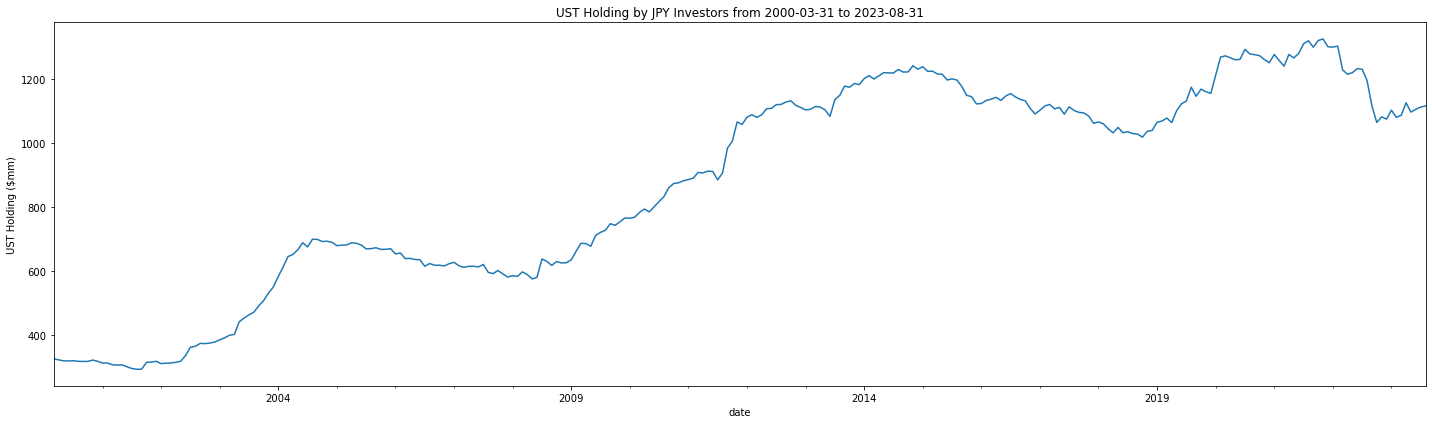

In [5]:
(df_jpy_hold.set_index(
    "date")
    ["PX_LAST"].
    plot(
        figsize = (20,6),
        ylabel = "UST Holding ($mm)",
        title = "UST Holding by JPY Investors from {} to {}".format(
            df_jpy_hold.date.min().date(),
            df_jpy_hold.date.max().date())))

plt.tight_layout()
plt.show()

In [6]:
df_combined = (df_yield.query(
    "country == 'USA'").
    set_index("date").
    resample("M").
    last().
    rename(columns = {"PX_LAST": "yield"}).
    merge(right = df_jpy_hold.rename(columns = {"PX_LAST": "holding"}), how = "inner", on = ["date"]).
    drop(columns = ["country", "security"]).
    dropna())

In [7]:
df_train, df_test = df_combined.query("date < '2015-01-01'"), df_combined.query("date >= '2015-01-01'")

# Holdings vs. 10y Yield

Established from the last model there is little relationship between hedge yield and Treasury holding, this is also doubled with the fact that FX carry-hedged weighting has negative yield. Therefore its important to find how much yields change with respect to decrease in holding

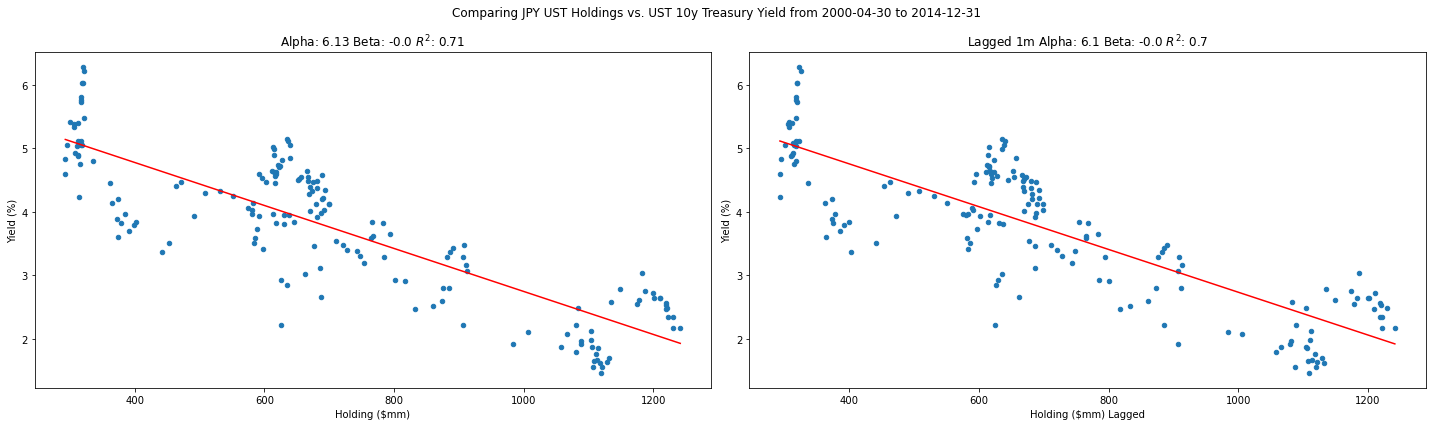

In [8]:
regress_lag_regress(
    df = df_train, endog = "yield", exog = "holding",
    xlabel = "Holding ($mm)", ylabel = "Yield (%)",
    compare = "JPY UST Holdings vs. UST 10y Treasury Yield")

Although there is a strong relationship it is likely an incrase in UST Holdings while rates have fallen. Let's make a yield richness and cheapness indicator for yields and then compare against holdings.

In [9]:
window = 252

df_zscore = (df_yield.query(
    "country == 'USA'").
    drop(columns = ["country"]).
    rename(columns = {"PX_LAST": "rate"}).
    assign(z_score = lambda x: (x.rate - x.rate.rolling(window = window).mean()) / x.rate.rolling(window = window).std()).
    dropna().
    rename(columns = {"rate": "yield"}).
    merge(right = df_train, how = "inner", on = ["date", "yield"]).
    assign(holding_change = lambda x: x.holding.pct_change() * 100).
    dropna())

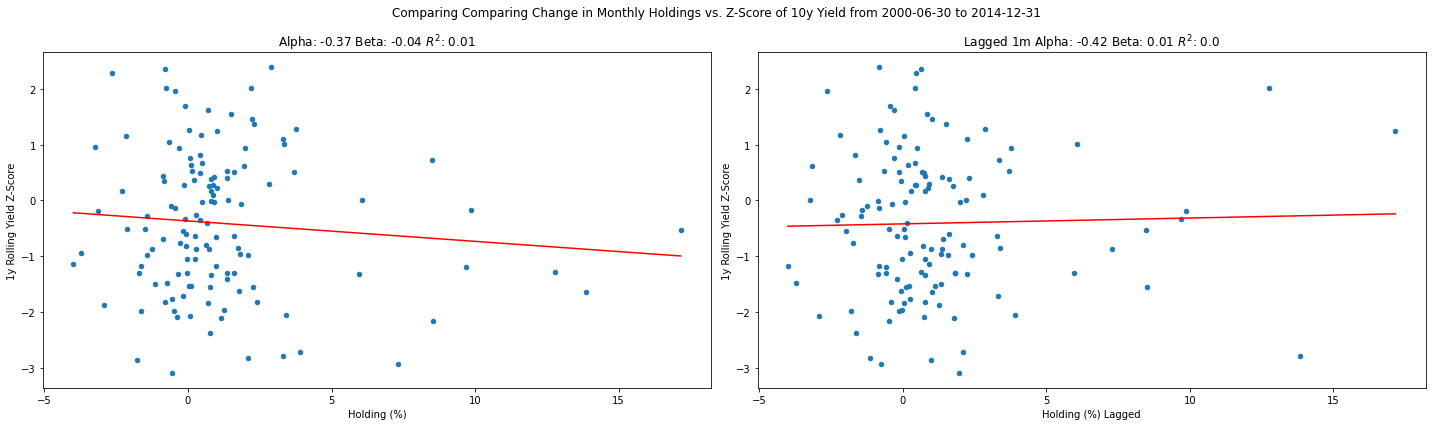

In [10]:
regress_lag_regress(
    df = df_zscore, endog = "z_score", exog = "holding_change",
    xlabel = "Holding (%)", ylabel = "1y Rolling Yield Z-Score",
    compare = "Comparing Change in Monthly Holdings vs. Z-Score of 10y Yield")

This shows that holdings don't change with respect to z-score of yield. 

Let's examine the change in yield vs. change in holdings. There is likely to be a relationship, but it probably only exist in intraday or daily. 

In [11]:
df_change = (df_train.assign(
    yield_one_change = lambda x: x["yield"].pct_change() * 100,
    yield_two_change = lambda x: x["yield"].pct_change(periods = 2) * 100,
    holding_change = lambda x: x.holding.pct_change() * 100).
    dropna())

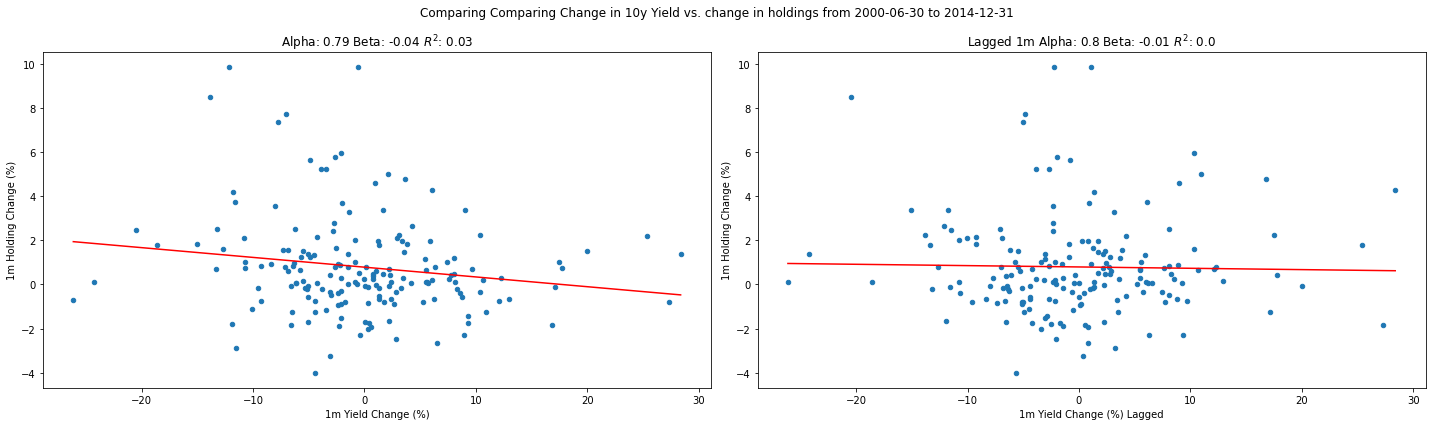

In [12]:
regress_lag_regress(
    df = df_change, endog = "holding_change", exog = "yield_one_change",
    xlabel = "1m Yield Change (%)", ylabel = "1m Holding Change (%)",
    compare = "Comparing Change in 10y Yield vs. change in holdings")

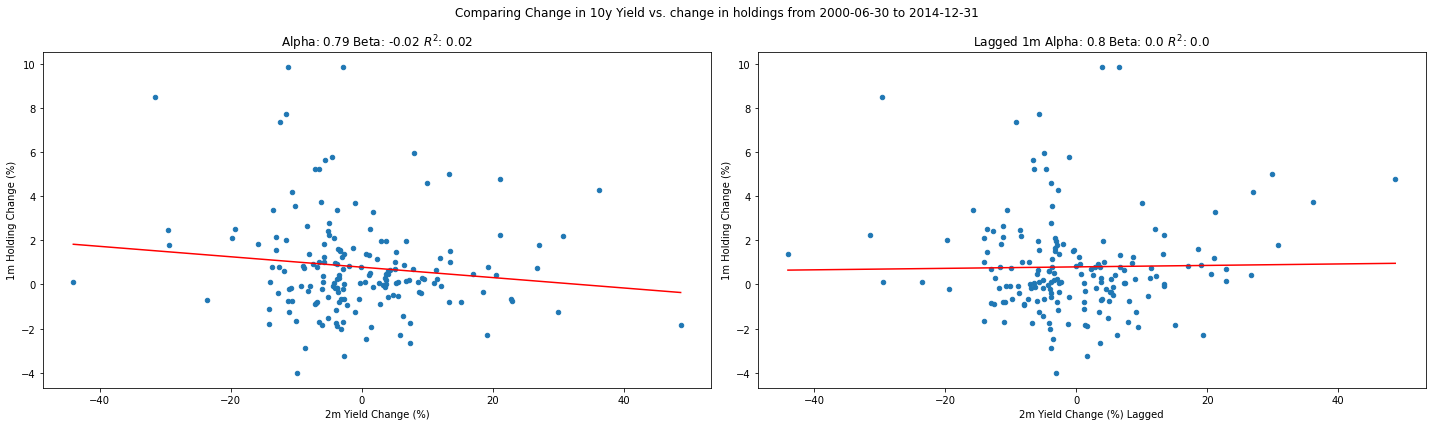

In [13]:
regress_lag_regress(
    df = df_change, endog = "holding_change", exog = "yield_two_change",
    xlabel = "2m Yield Change (%)", ylabel = "1m Holding Change (%)",
    compare = "Change in 10y Yield vs. change in holdings")

# Holdings vs. FX Unhedged rate

In [14]:
window = 3

df_diff = (df_yield.pivot(
    index = "date", columns = "country", values = "PX_LAST").
    reset_index().
    assign(
        spread = lambda x: x.USA - x.JPY,
        month_year = lambda x: x.date.dt.year.astype(str) + "-" + x.date.dt.month.astype(str)).
    dropna()
    [["date", "month_year", "spread"]].
    merge(
        right = (df_train.assign(
            month_year = lambda x: x.date.dt.year.astype(str) + "-" + x.date.dt.month.astype(str)).
            drop(columns = ["date"])), 
        how = "inner", 
        on = ["month_year"]).
    set_index("date").
    resample("M").
    last().
    assign(
        spread_diff = lambda x: x.spread.diff(),
        holding_change = lambda x: x.holding.pct_change() * 100,
        z_score = lambda x: (x.spread - x.spread.rolling(window = window).mean()) / x.spread.rolling(window = window).std()).
    dropna())

USD-JPY Differential vs. Holding

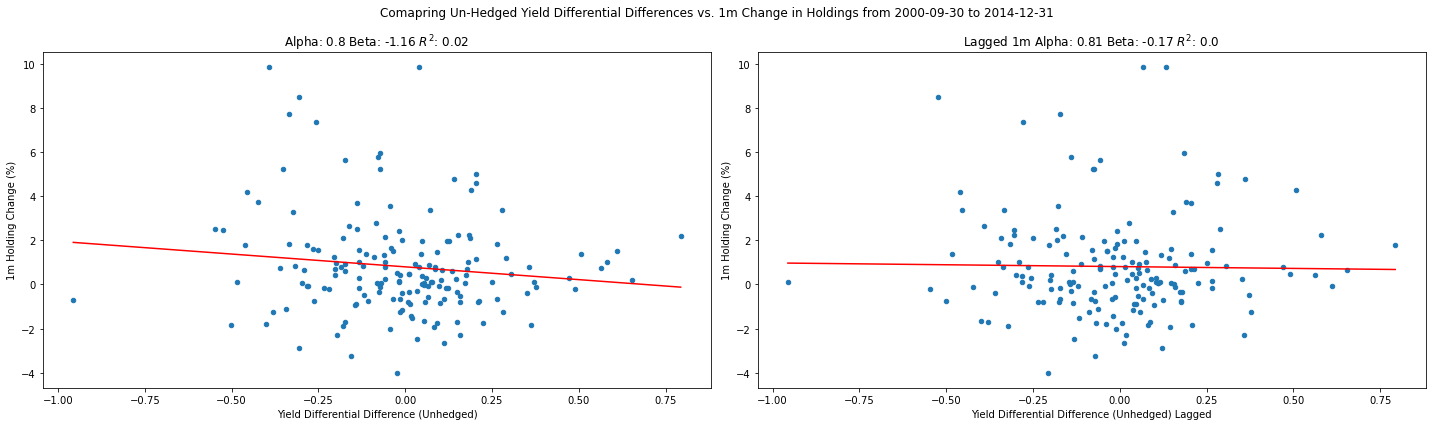

In [15]:
regress_lag_regress(
    df = df_diff, endog = "holding_change", exog = "spread_diff",
    xlabel = "Yield Differential Difference (Unhedged)", ylabel = "1m Holding Change (%)",
    compare = "Un-Hedged Yield Differential Differences vs. 1m Change in Holdings")

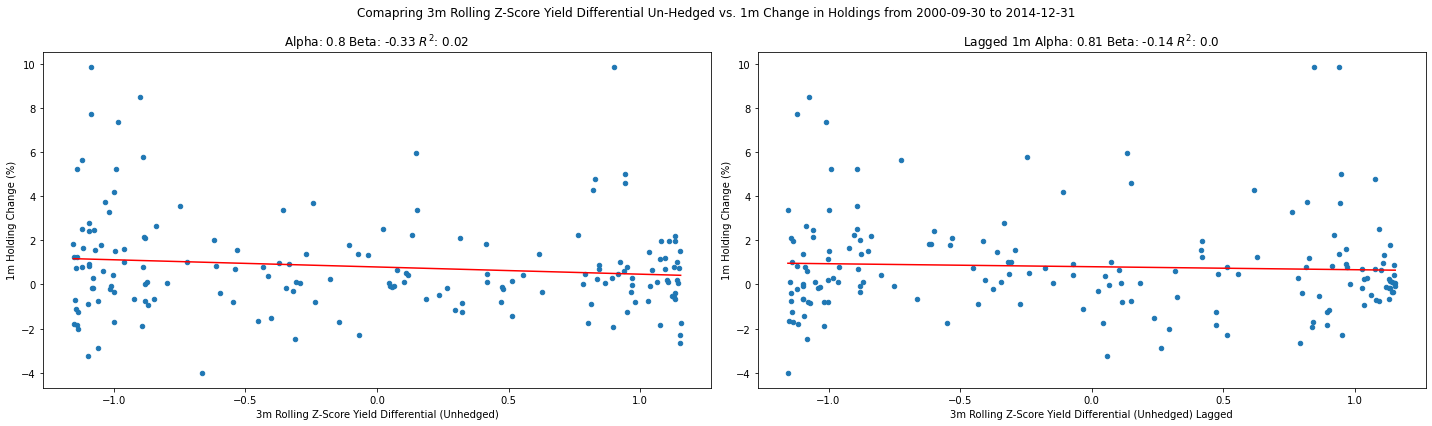

In [16]:
regress_lag_regress(
    df = df_diff, endog = "holding_change", exog = "z_score",
    xlabel = "3m Rolling Z-Score Yield Differential (Unhedged)", ylabel = "1m Holding Change (%)",
    compare = "3m Rolling Z-Score Yield Differential Un-Hedged vs. 1m Change in Holdings")

# Holding vs. Hedged Yield

In [17]:
df_hedged = (df_hc.assign(
    year_month = lambda x: x.date.dt.year.astype(str) + "-" + x.date.dt.month.astype(str)).
    merge(
        right = (df_train.assign(
            year_month = lambda x: x.date.dt.year.astype(str) + "-" + x.date.dt.month.astype(str)).
            drop(columns = ["date"])),
        how = "inner",
        on = ["year_month"]).
    set_index("date").
    groupby("period").
    resample("M").
    last().
    drop(columns = ["period"]).
    reset_index().
    assign(hedged_yield = lambda x: x["yield"] - x.hc))

In [18]:
df_hedge_diff = (df_hedged[
    ["period", "year_month", "hedged_yield"]].
    assign(year_month = lambda x: pd.to_datetime(x.year_month, format = "%Y-%m")).
    pivot(index = "year_month", columns = "period", values = "hedged_yield").
    diff().
    dropna().
    reset_index().
    melt(id_vars = "year_month", value_name = "yield_diff").
    merge(
        right = (df_hedged[
            ["year_month", "holding", "date"]].
            assign(year_month = lambda x: pd.to_datetime(x.year_month, format = "%Y-%m")).
            drop_duplicates().
            assign(holding_change = lambda x: x.holding.pct_change() * 100)),
        how = "inner",
        on = ["year_month"]))

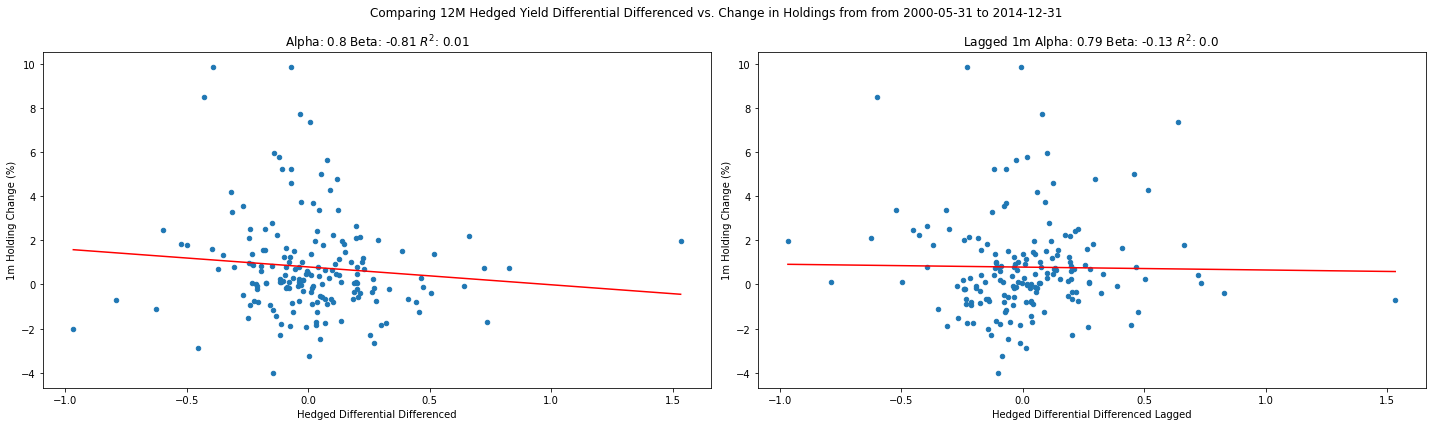

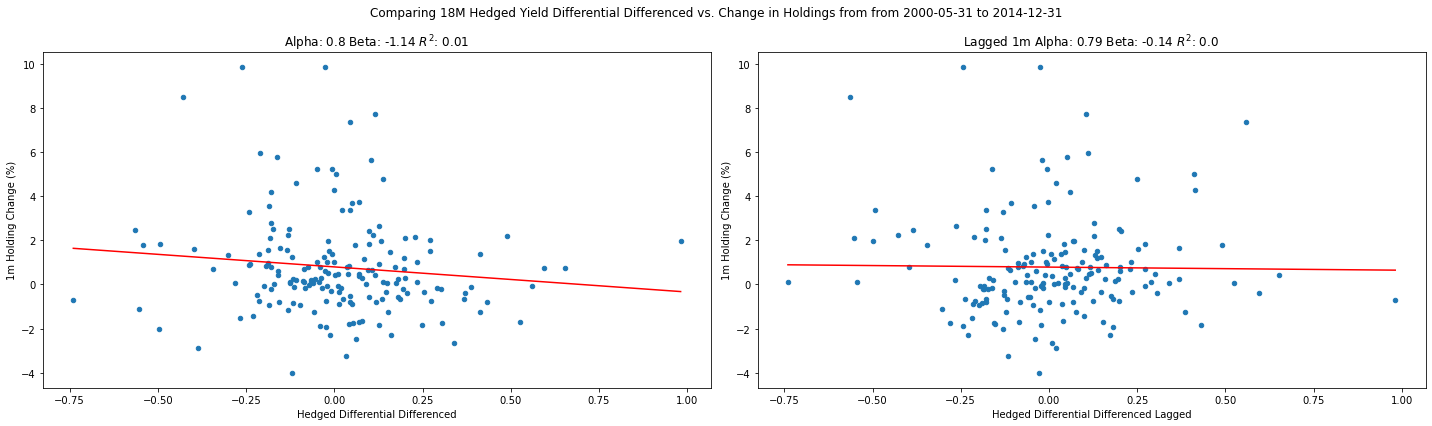

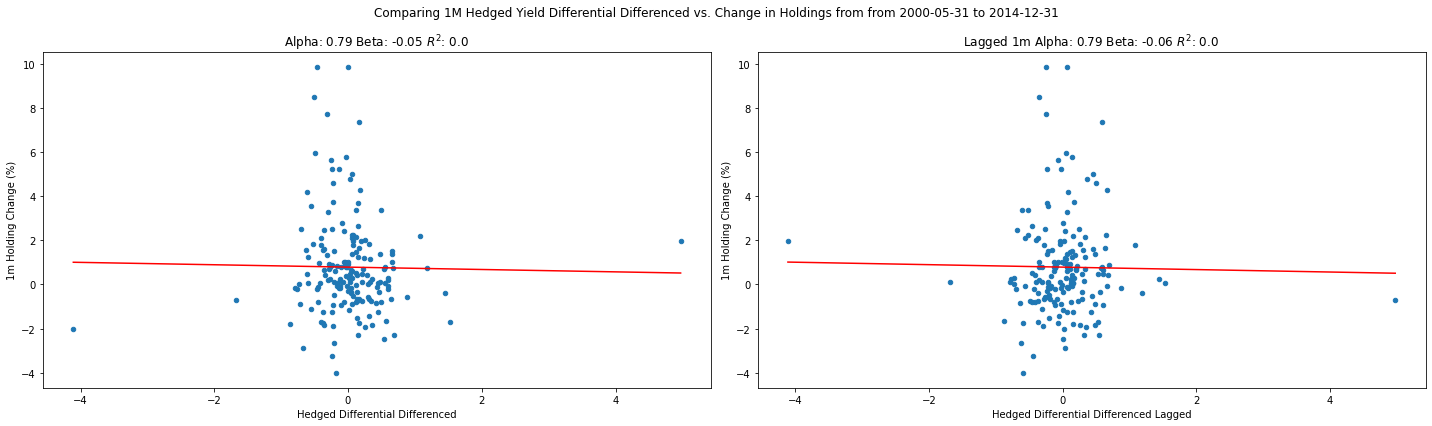

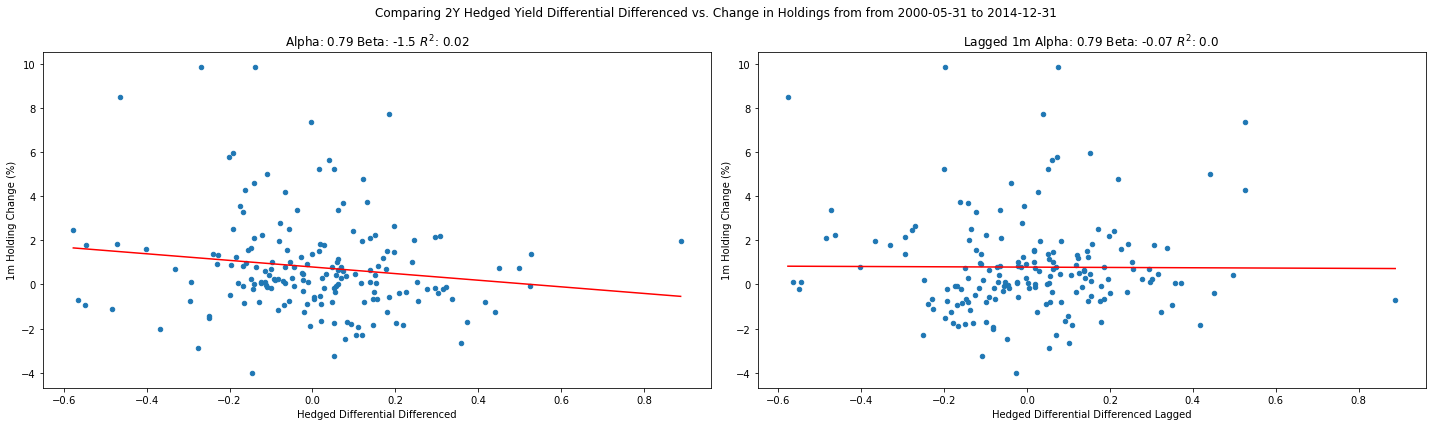

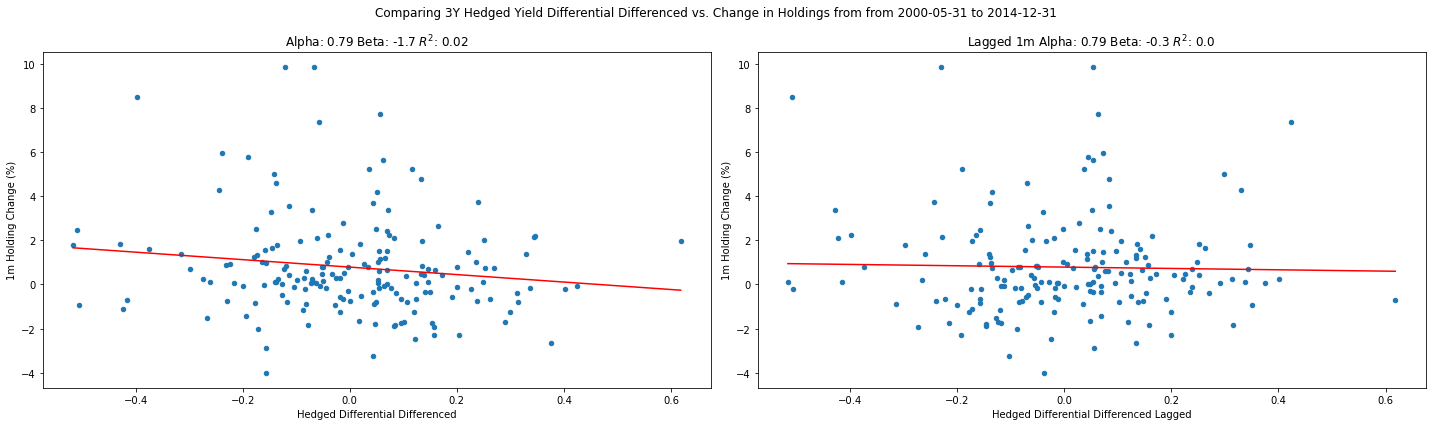

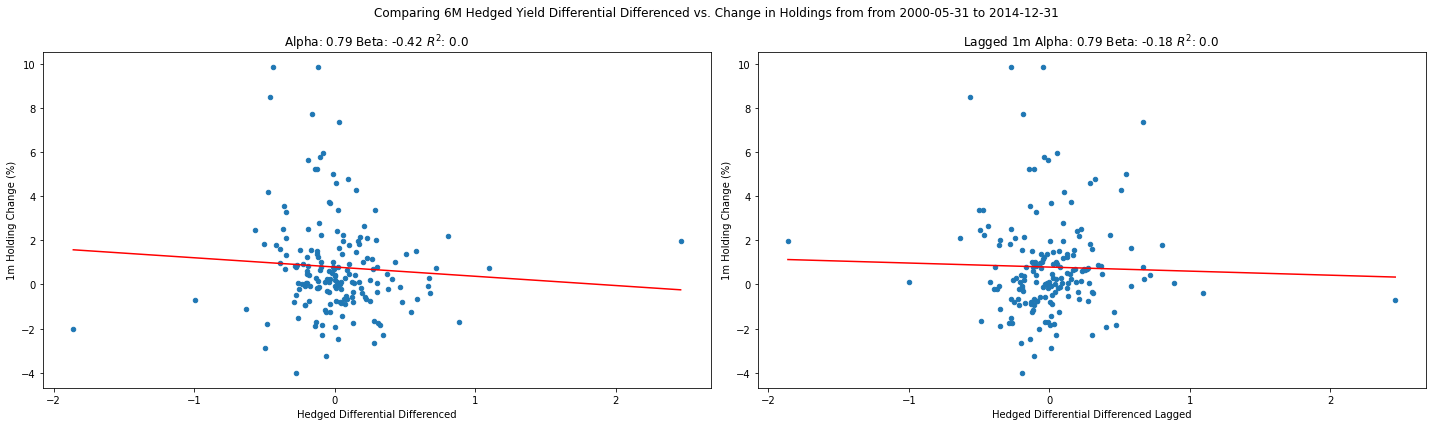

In [19]:
for period in df_hedge_diff.period.drop_duplicates().to_list():
    
    df_tmp = df_hedge_diff.query("period == @period")
    regress_lag_regress(
        df = df_tmp, endog = "holding_change", exog = "yield_diff",
        xlabel = "Hedged Differential Differenced", ylabel = "1m Holding Change (%)",
        compare = "{} Hedged Yield Differential Differenced vs. Change in Holdings from".format(period))

# Holding vs. JPY Yield

In [20]:
def _get_last(df: pd.DataFrame) -> pd.DataFrame: return(df.query("date == date.max()"))

df_jpy_diff = (df_yield.query(
    "country == 'JPY'").
    rename(columns = {"PX_LAST": "jpy_yield"}).
    drop(columns = ["country"]).
    assign(year_month = lambda x: x.date.dt.year.astype(str) + "-" + x.date.dt.month.astype(str)).
    merge(
        right = (df_train.assign(
            year_month = lambda x: x.date.dt.year.astype(str) + "-" + x.date.dt.month.astype(str)).
            drop(columns = ["date"])),
        how = "inner",
        on = ["year_month"]).
    groupby("year_month").
    apply(_get_last).
    drop(columns = ["year_month"]).
    reset_index().
    drop(columns = ["level_1"]).
    sort_values("date").
    assign(
        jpy_diff = lambda x: x.jpy_yield.diff(),
        holding_change = lambda x: x.holding.pct_change()).
    dropna())

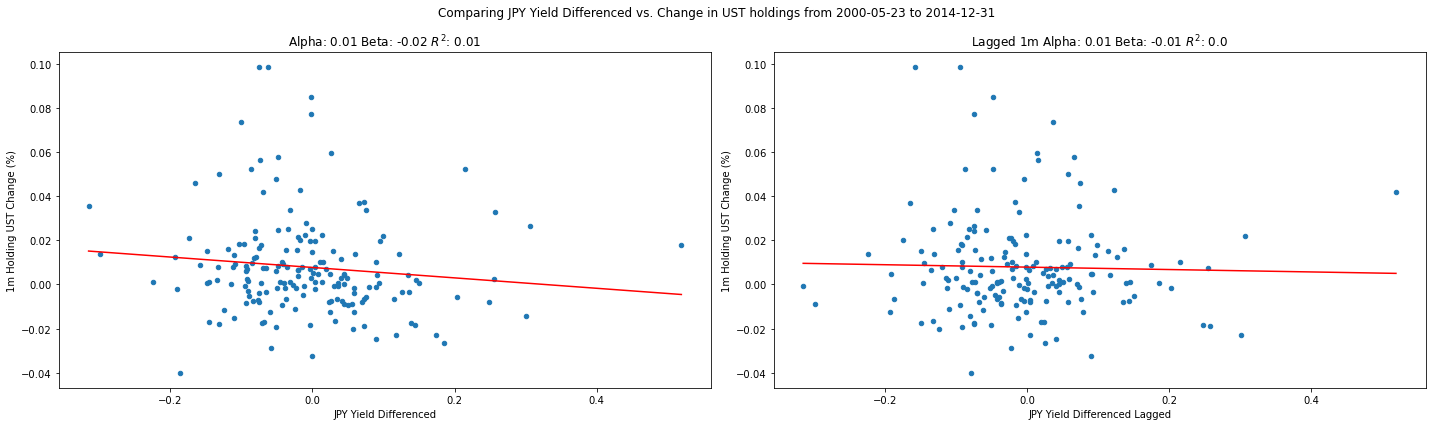

In [21]:
regress_lag_regress(
        df = df_jpy_diff, endog = "holding_change", exog = "jpy_diff",
        xlabel = "JPY Yield Differenced", ylabel = "1m Holding UST Change (%)",
        compare = "JPY Yield Differenced vs. Change in UST holdings")